# Automatic question categorization (modelisation)
Pierre-Yves BOISBUNON - February 2018

----------

In this notebook, we will continue the categorization job to establish using non-supervised technics.

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from __future__ import division
import utils

# 1 Import clean dataset

First open previously stored cleaned dataset:

In [195]:
df = pd.read_csv('dataset_clean.csv', sep='\t')
df.head()

,index,Body,Title,Tags,y,raw,raw_letter
0,0,<p>I have two dataframes that I'm trying to co...,How to combine two differently multi-indexed p...,python|pandas,python pandas,I have two dataframes that I'm trying to combi...,have two dataframes that try to combine they e...
1,2,"<p>I have Eclipse CDT Oxygen on Ubuntu 16.04, ...",Eclipse CDT Oxygen with LLVM support forces st...,c++|llvm|ubuntu-16.04|eclipse-cdt|clang++,c++,"I have Eclipse CDT Oxygen on Ubuntu 16.04, wit...",have eclipse cdt oxygen on ubuntu with the llv...
2,3,<p>I use ' SelectionMode : Row ' now</p>\n\n<p...,How to get selected row in C1flexgrid?,c#|c1flexgrid,c#,I use ' SelectionMode : Row ' now\n\nI already...,use selectionmode row now already use mousecli...
3,5,"<p>So I have 24 ""person"" objects, which I crea...","Javascript, map returns undefined",javascript|arrays|object|dictionary,javascript arrays,"So I have 24 ""person"" objects, which I created...",so have person object which create use name ar...
4,6,<p>I want to extract only jms message text wit...,Extract jms text content,java|jms|message-queue,java,I want to extract only jms message text withou...,want to extract only jms message text without ...


In [196]:
df['y'] = df['y'].apply(lambda x: x.split())

In [197]:
y = df['y'].tolist()
list_of_tags = list(set([y_item_item for y_item in y for y_item_item in y_item]))
list_of_tags

['django',
 'c',
 'node.js',
 'html',
 'pandas',
 'mysql',
 'angularjs',
 'sql',
 'c#',
 'reactjs',
 'ios',
 'jquery',
 'regex',
 'firebase',
 'python-3.x',
 'excel',
 'css',
 'java',
 'android',
 'python',
 'arrays',
 'angular',
 'swift',
 'c++',
 'r',
 'typescript',
 'laravel',
 'javascript',
 'php',
 'json']

Let's define a **random state** in order models are computed with the same values.

In [198]:
# Random state in order to force computation with the same results
random_state = 100

Let's also define some **utils functions** that will help to factorize codes and simplify jobs.

## 1.1 Utils functions

This function function print top **n_top_words** words from the **model** components based on **features_names** values.

In [199]:
def print_top_words(model, feature_names, n_top_words):
    """Print the n_top_words from the model components
    based on features_names values.
    """
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        topic_arr = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(topic_arr)
        message += " ".join(topic_arr)
        print(message)
    print()
    return top_words

This function plot distribution of the **n_topics** included in **X_topics** array.

In [200]:
def plot_topic_distribution(n_topics, X_topics):
    """Plot distribution of the n_topics included in the X_topics array.
    """
    dist = [0] * n_topics
    for x_topics in X_topics:
        highest_topic = x_topics.argsort()[-3:][::-1][0]
        dist[highest_topic] += 1
    plt.bar(range(n_topics), dist)

This function plot **topics** as wordcloud:

In [201]:
from wordcloud import WordCloud

def topicWordCloud(model, feature_names, topicNumber, WCmaxWords,WCwidth, WCheight):
    """Compute wordcloud object based on features names of the model
    """
    topic = model.components_[topicNumber]
    tupleList = [(feature_names[i],int(topic[i]/topic.sum()*10000)) for i in range(len(topic))]
    for key, value in tupleList: cnt[key] = value
    wordcloud = WordCloud(width=WCwidth, 
                          height=WCheight, 
                          max_words=WCmaxWords, 
                          random_state=42,
                          background_color='white').generate_from_frequencies(cnt)
    return wordcloud

def print_topicWordCloud(model, feature_names, n_topics, n_columns, n_rows):
    """Display all wordcloud for the n_topics of the model
    """
    fig = plt.figure(figsize=(20, 20))
    for i in range(n_topics):
            ax = plt.subplot(n_rows, n_columns, i+1)
            wordcloud = topicWordCloud(model, 
                                       feature_names, 
                                       i, 
                                       WCmaxWords=10,
                                       WCwidth=1200, 
                                       WCheight=1200)
            ax.imshow(wordcloud)
            ax.axis('off')
            ax.set(title='topic %d' %i)

This function compute word similarity treatment based on pre-trained model available here:http://nlp.stanford.edu/data/glove.6B.zip

For that we will use word2vec model.

For each topic we will take the **n** first top word with the highest number of similar words.

In [127]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2018-10-18 21:33:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-10-18 21:33:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip.1'

glove.6B.zip.1        0%[                    ]   2.37M   713KB/s    eta 19m 59s^C


In [11]:
!unzip glove.6B.zip -d .

Archive:  glove.6B.zip
  inflating: ./glove.6B.50d.txt      
  inflating: ./glove.6B.100d.txt     
  inflating: ./glove.6B.200d.txt     
  inflating: ./glove.6B.300d.txt     


In [12]:
!ls

P6-Categoriser automatiquement des questions.pptx
QueryResults.csv
__pycache__
api
dataset_clean.csv
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
glove.6B.50d.txt
glove.6B.zip
img
notebook_cleaning_and_exploration.ipynb
notebook_modelisation_nonsupervisee.ipynb
notebook_modelisation_supervisee.ipynb
utils.py


In [14]:
!pip install gensim

    100% |################################| 23.6MB 1.9MB/s ta 0:00:01
    100% |################################| 1.4MB 1.4MB/s ta 0:00:011
    100% |################################| 133kB 4.1MB/s ta 0:00:01
    100% |################################| 61kB 3.6MB/s ta 0:00:01
    100% |################################| 4.7MB 1.5MB/s ta 0:00:011
    100% |################################| 552kB 8.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec('glove.6B.300d.txt', 'glove.6B.300d_converted.txt')

(400000, 300)

In [16]:
import gensim
# Import the word2vec model
model_path = 'glove.6B.300d_converted.txt'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

In [128]:
def filter_by_similarity(w2v_model, n_topics, top_words_arr, n=3):
    """Create array computed each word similarity based on top_words_arr for
    the n_topics.
    """
    nb_common_words_arr_topics = []
    for idx_topic in range(n_topics):
        nb_common_words_arr = []
        for word in top_words_arr[idx_topic]:
            nb_common_words = 0
            try:
                # Find all similar words
                res_arr = w2v_model.most_similar(positive=word, topn=30)
                for res in res_arr:
                    try:
                        # if word is found in the topic top words
                        if top_words_arr[idx_topic].index(res[0]):
                            nb_common_words += 1
                    except:
                        # Not found in to top_words_arr
                        pass
            except:
                # no similar word found
                pass
            nb_common_words_arr.append(nb_common_words)
        nb_common_words_arr_topics.append(nb_common_words_arr)
    # Create final top array    
    top_words_arr_final = []
    for idx_topic in range(n_topics):
        top_words_arr_final.append([top_words_arr[idx_topic][i] for i in sorted(range(len(nb_common_words_arr_topics[idx_topic])), key=lambda i: nb_common_words_arr_topics[idx_topic][i], reverse=False)[-n:]])
    return top_words_arr_final

# 2 Non-Supervised method for tags prediction

For the modelisation, we wil use two different algorithms available in sklearn:

- Latent Dirichlet Allocation (LDA)
- Non-Negative Matrix Factorization (NMF)

This idea is to extract topic predicted by this 2 algorithms based on **raw_letter** information available in the dataset.

In [202]:
X = df["raw_letter"]

Let's import the useful modules requires for the rest of the notebook.

In [20]:
!pip install pyLDAvis

    100% |################################| 1.6MB 1.4MB/s ta 0:00:01
    100% |################################| 276kB 3.9MB/s ta 0:00:01
    100% |################################| 163kB 1.8MB/s ta 0:00:01
    100% |################################| 215kB 1.2MB/s ta 0:00:01
    100% |################################| 51kB 2.1MB/s ta 0:00:01
    100% |################################| 92kB 4.6MB/s ta 0:00:011
  Running setup.py bdist_wheel for pyLDAvis ... done
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [204]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from time import time
from sklearn.manifold import TSNE
import pyLDAvis.sklearn

As the idea is to extract from topic predicted by the LDA and NMF algorithms, we need to evaluate our model. 
To do so, we choose to compose tags extracted by these 2 algorithms with the ones provided by StackOverflow (information available in y raw)

Let's first define some candidates to evaluate the model:

In [205]:
print("Candidate 0: Question extracted: '%s'" %X[0][:100], "\n\t     Tags from StackOverflow: '%s'" %' '.join(df['y'][0]))
print("Candidate 1: Question extracted: '%s'" %X[1][:100], "\n\t     Tags from StackOverflow: '%s'" %' '.join(df['y'][1]))
print("Candidate 5: Question extracted: '%s'" %X[5][:100], "\n\t     Tags from StackOverflow: '%s'" %' '.join(df['y'][5]))
print("Candidate 3: Question extracted: '%s'" %X[3][:100], "\n\t     Tags from StackOverflow: '%s'" %' '.join(df['y'][3]))
print("Candidate 18: Question extracted: '%s'" %X[18][:100], "\n\t     Tags from StackOverflow: '%s'" %' '.join(df['y'][18]))
print("Candidate 20: Question extracted: '%s'" %X[20][:100], "\n\t     Tags from StackOverflow: '%s'" %' '.join(df['y'][20]))

Candidate 0: Question extracted: 'have two dataframes that try to combine they each have multiindex but those index have no overlap le' 
	     Tags from StackOverflow: 'python pandas'
Candidate 1: Question extracted: 'have eclipse cdt oxygen on ubuntu with the llvm support instal llvm be instal and want to experiment' 
	     Tags from StackOverflow: 'c++'
Candidate 5: Question extracted: 'build an app that will contain number of route each define an ngmodule each module be pretty similar' 
	     Tags from StackOverflow: 'angular typescript'
Candidate 3: Question extracted: 'so have person object which create use name array so that dude name be repeat next make function tha' 
	     Tags from StackOverflow: 'javascript arrays'
Candidate 18: Question extracted: 'problem be try to manually validate some c# object and the validator be ignore string length relate ' 
	     Tags from StackOverflow: 'c#'
Candidate 20: Question extracted: 'have never see this before and wonder how it would be po

These candidates will then be used to evaluate the different models.

Let's define also a global function that evaluate the model. That's the entry function to evaluate the model.

In [206]:
def evaluate_model_get_real_and_propose(idx, df, X_topics, top_words_arr):
    top_three = X_topics[idx].argsort()[-3:][::-1]
    tmp = [ top_words_arr[i] for i in top_three]
    tmp = tmp[:3]
    return ' '.join(df['y'][idx]), ' '.join(' '.join([x for sublist in tmp for x in sublist]).split()[:3])

def evaluate_model(df, X_topics, top_words_arr):
    """Entry point to evaluate models based on 4 selected questions.
    """
    stackoverflow_tags = []
    proposed_tags = []
    topic_list = ['Question 0', 'Question 1', 'Question 5', 'Question 3', 'Question 18', 'Question 20']
    x, y = evaluate_model_get_real_and_propose(0, df, X_topics, top_words_arr)
    stackoverflow_tags.append(x)
    proposed_tags.append(y)
    x, y = evaluate_model_get_real_and_propose(1, df, X_topics, top_words_arr)
    stackoverflow_tags.append(x)
    proposed_tags.append(y)
    x, y = evaluate_model_get_real_and_propose(5, df, X_topics, top_words_arr)
    stackoverflow_tags.append(x)
    proposed_tags.append(y)
    x, y = evaluate_model_get_real_and_propose(3, df, X_topics, top_words_arr)
    stackoverflow_tags.append(x)
    proposed_tags.append(y)
    x, y = evaluate_model_get_real_and_propose(18, df, X_topics, top_words_arr)
    stackoverflow_tags.append(x)
    proposed_tags.append(y)
    x, y = evaluate_model_get_real_and_propose(20, df, X_topics, top_words_arr)
    stackoverflow_tags.append(x)
    proposed_tags.append(y)
    my_df = pd.DataFrame({'Tags from stackoverflow': stackoverflow_tags, 'Tag proposed': proposed_tags}, index=topic_list)
    return my_df

## 2.1 Optimize feature selections

Let's recall the hyperparameters **max_df**/**min_df** that we previously found

In [207]:
max_df = 0.2
min_df = 100

## 2.3 NMF Model

Let's build NMF model first.
In that case, NMF uses TfidfVectorizer. Let's use the same hyperparameters the ones we identified during supervised modelisation.

In [208]:
# TFIDF transformer
tfidf_vect = TfidfVectorizer(max_df=max_df, min_df=min_df,
                             stop_words='english',
                             lowercase=True,
                             use_idf=True, norm='l2')
tfidf = tfidf_vect.fit_transform(X)
feature_names = tfidf_vect.get_feature_names()

### 2.3.1 With 20 topics

Let's start with 20-topics

In [209]:
n_topics = 20
nmf = NMF(n_components=n_topics, random_state=random_state)
X_topics = nmf.fit_transform(tfidf)
n_top_words = 10
top_words_arr = print_top_words(nmf, feature_names, n_top_words)

Topic #0: test run project app version build application time library method
Topic #1: div id span script src html img href colmd row
Topic #2: public void private override set null static view int method
Topic #3: python import print def self line lib module init sitepackages
Topic #4: android layoutheight layoutwidth id dp matchparent app wrapcontent schemasandroidcom apk
Topic #5: column df row dataframe pandas index col nan cell na
Topic #6: array object element key arrays index php arr numpy loop
Topic #7: file line path folder read upload filename directory open csv
Topic #8: td tr th table tbody row thead php echo html
Topic #9: string character map json regex key word match type convert
Topic #10: var consolelog script object let javascript true result variable false
Topic #11: image img url upload let src size view load width
Topic #12: int std char include const vector cout struct void printf
Topic #13: button input type text form click label id option field
Topic #14: list i

Let's display all topics as wordcloud

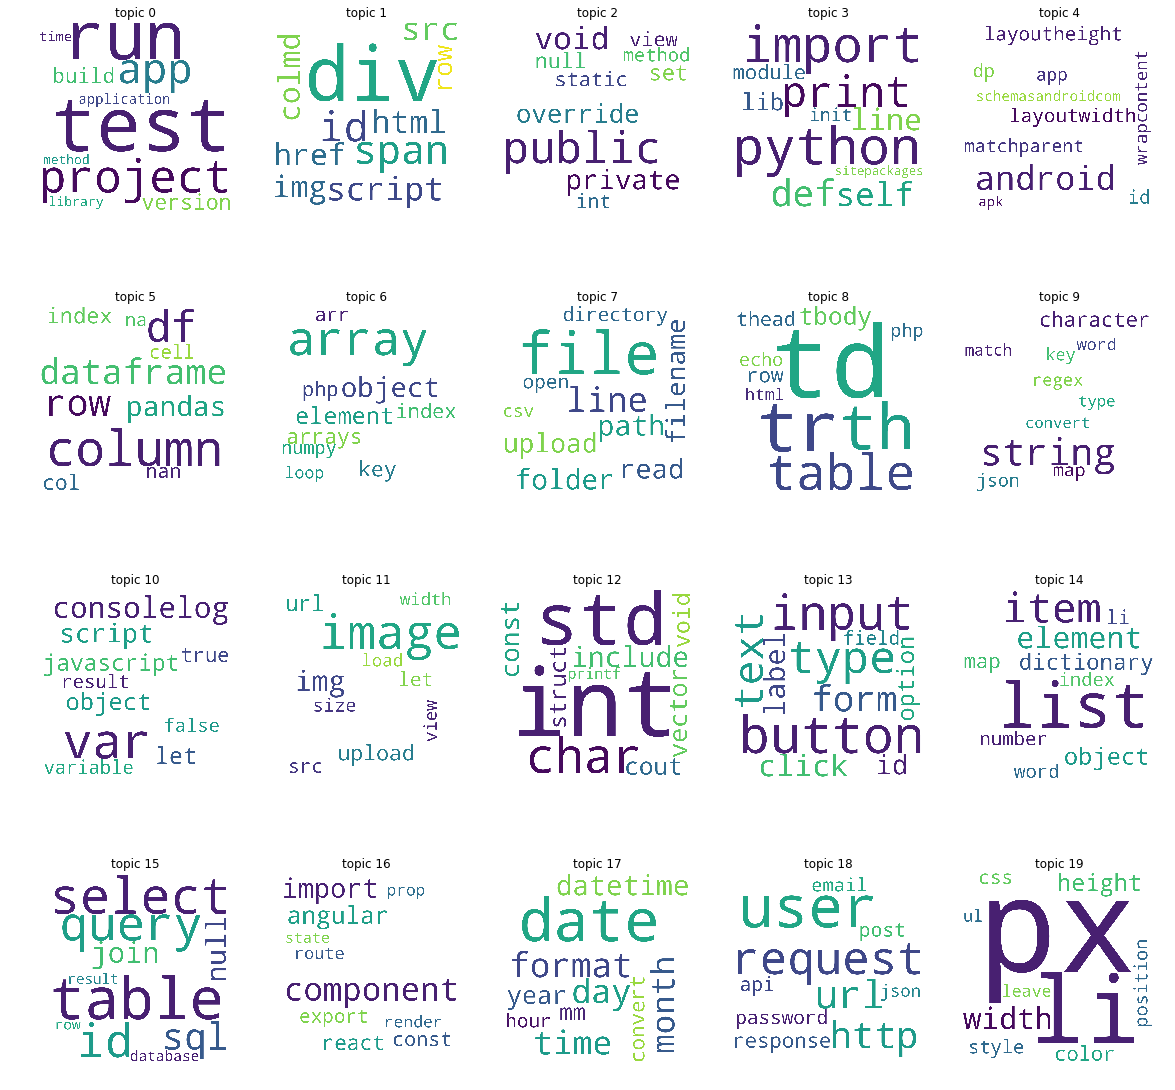

In [210]:
print_topicWordCloud(nmf, feature_names, 20, 5, 4)

If we evaluate the model now:

In [211]:
evaluate_model(df, X_topics, top_words_arr)

,Tag proposed,Tags from stackoverflow
Question 0,column df row,python pandas
Question 1,int std char,c++
Question 5,component import angular,angular typescript
Question 3,var consolelog script,javascript arrays
Question 18,var consolelog script,c#
Question 20,button input type,ios swift


Now if we try to filter the word by similarity (removing words that are not close) we can see:

In [212]:
top_words_arr_final = filter_by_similarity(model, n_topics, top_words_arr)
top_words_arr_final

[['project', 'app', 'build'],
 ['row', 'src', 'img'],
 ['public', 'void', 'null'],
 ['module', 'init', 'sitepackages'],
 ['schemasandroidcom', 'apk', 'android'],
 ['nan', 'cell', 'na'],
 ['array', 'object', 'element'],
 ['file', 'directory', 'folder'],
 ['echo', 'php', 'html'],
 ['match', 'type', 'convert'],
 ['result', 'variable', 'false'],
 ['src', 'size', 'width'],
 ['struct', 'void', 'printf'],
 ['button', 'type', 'form'],
 ['item', 'element', 'object'],
 ['query', 'sql', 'database'],
 ['state', 'import', 'export'],
 ['month', 'hour', 'day'],
 ['response', 'password', 'url'],
 ['px', 'width', 'height']]

We can see that for topic 8, keywords html and php are correctly filtered.

If we also evaluate the results after our post-treatment

In [213]:
evaluate_model(df, X_topics, top_words_arr_final)

,Tag proposed,Tags from stackoverflow
Question 0,nan cell na,python pandas
Question 1,struct void printf,c++
Question 5,state import export,angular typescript
Question 3,result variable false,javascript arrays
Question 18,result variable false,c#
Question 20,button type form,ios swift


We can see that our tag proposed seem not to be quite good:
The tags proposed for questions 0/18 are not pertinent.

### 2.3.3 With 40 topics

Let's work with 40-topics now!

In [214]:
n_topics = 40
nmf = NMF(n_components=n_topics, random_state=random_state)
X_topics = nmf.fit_transform(tfidf)
n_top_words = 20
top_words_arr = print_top_words(nmf, feature_names, n_top_words)

Topic #0: app run project version build application server library time compile package java dependency window wa node start doe ve issue
Topic #1: div span colmd img label classname html href container style src formgroup colsm content modal display formcontrol alt element flex
Topic #2: public void private override set static null view method context final extend intent protect exception savedinstancestate entity activity boolean textview
Topic #3: import module export numpy np angular package core http main plot private def plt ngmodule matplotlibpyplot initpy appcomponent pd matplotlib
Topic #4: android layoutheight layoutwidth dp matchparent wrapcontent app schemasandroidcom apk xmlns activity textview studio linearlayout layout xml tool view intent drawable
Topic #5: column dataframe pandas sum base frame number example look index contain table unique excel datatable sort ha col nan apply
Topic #6: array element arrays index arr numpy loop result nparray size matrix number sort f

And display topics as wordcloud:

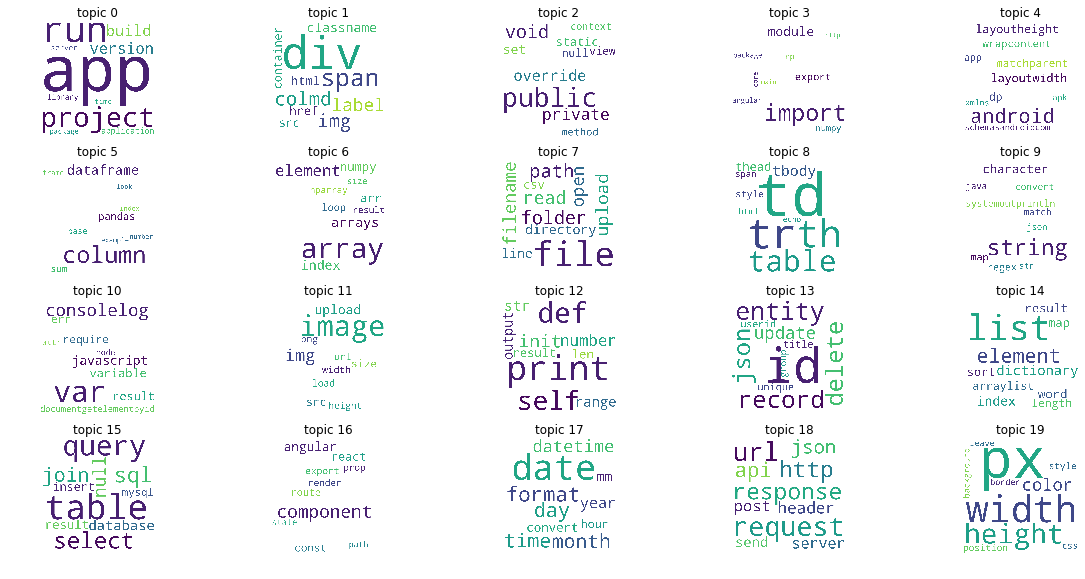

In [215]:
print_topicWordCloud(nmf, feature_names, 20, 5, 8)

What we can see is that we have more information related to topics extracted:
- topic 30 can be interpreted as type definition.
- topic 31/32/28 for example give clear information (one for html, one for python and another one for pandas)

What we discover is that:
- we also have topic that show information quite close (topic 28 and 5 are related to pandas).

If we evaluate the model now:

In [216]:
evaluate_model(df, X_topics, top_words_arr)

,Tag proposed,Tags from stackoverflow
Question 0,df dataframe pandas,python pandas
Question 1,python line lib,c++
Question 5,component angular react,angular typescript
Question 3,var consolelog javascript,javascript arrays
Question 18,var consolelog javascript,c#
Question 20,button click event,ios swift


- keywords for question 0/5/3 are correct.
- keywords for question 1/18/20 are far from the ones from StackOverflow.

Let's filter now the words of each topic by similarity:

In [217]:
top_words_arr_final = filter_by_similarity(model, n_topics, top_words_arr, n=3)
top_words_arr_final

[['java', 'start', 'run'],
 ['flex', 'img', 'src'],
 ['public', 'void', 'null'],
 ['import', 'np', 'core'],
 ['intent', 'drawable', 'android'],
 ['apply', 'unique', 'sort'],
 ['size', 'shape', 'dimension'],
 ['pdf', 'excel', 'txt'],
 ['span', 'width', 'align'],
 ['contain', 'replace', 'result'],
 ['ajax', 'javascript', 'jquery'],
 ['camera', 'photo', 'image'],
 ['main', 'format', 'count'],
 ['createdat', 'model', 'category'],
 ['integer', 'list', 'element'],
 ['server', 'sql', 'database'],
 ['route', 'path', 'parent'],
 ['hour', 'week', 'day'],
 ['http', 'server', 'client'],
 ['position', 'background', 'display'],
 ['validation', 'type', 'form'],
 ['username', 'password', 'login'],
 ['weak', 'iboutlet', 'uiviewcontroller'],
 ['choose', 'select', 'selection'],
 ['iostream', 'type', 'main'],
 ['step', 'environment', 'selenium'],
 ['html', 'tab', 'click'],
 ['open', 'menu', 'button'],
 ['label', 'library', 'variable'],
 ['item', 'add', 'remove'],
 ['set', 'blank', 'break'],
 ['javascript'

What we can see for example:
- topic 30 seem to have changed (previously we interpreted this topic based on true/false/null/bool keywords
- topic 36 seems to give an other information giving priority to wordpress keyword, quite consistent with php/form keywords.

Let's evaluate our model:

In [218]:
evaluate_model(df, X_topics, top_words_arr_final)

,Tag proposed,Tags from stackoverflow
Question 0,label library variable,python pandas
Question 1,initpy line run,c++
Question 5,route path parent,angular typescript
Question 3,ajax javascript jquery,javascript arrays
Question 18,ajax javascript jquery,c#
Question 20,open menu button,ios swift


Only question 3 seems to give correct keywords.

## 2.2 LDA Model

Let's work now with, LDA model using CountVectorizer matrix.
Let's build the model and extracting feature names.

In [219]:
# Bag of word vectorizer
vect = CountVectorizer(max_df=max_df, 
                       min_df=min_df,
                       stop_words='english',
                       lowercase=True,
                       tokenizer=lambda x: x.split(' '))
tf = vect.fit_transform(X)
# Collect features from CountVectorizer
feature_names = vect.get_feature_names()

### 2.2.1 With 10 topics

Let's start evaluating model using **10 topics**

In [220]:
# train LDA model
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=random_state)
X_topics = lda_model.fit_transform(tf)
n_top_words = 10
top_words_arr = print_top_words(lda_model, feature_names, n_top_words)

Topic #0: public string int void private null std static override set
Topic #1: file run c project version line build window test lib
Topic #2: http request url var user message response api json server
Topic #3: android id view app dp item layoutheight layoutwidth activity intent
Topic #4: array list object number string type result example key int
Topic #5: component import app let angular const event property export react
Topic #6: c column row date r df na cell time dataframe
Topic #7: div px button var text width li span id script
Topic #8: import print python def self line image true func python-3.x
Topic #9: id table td select query php user database tr field



and displaying topic as WordCloud:

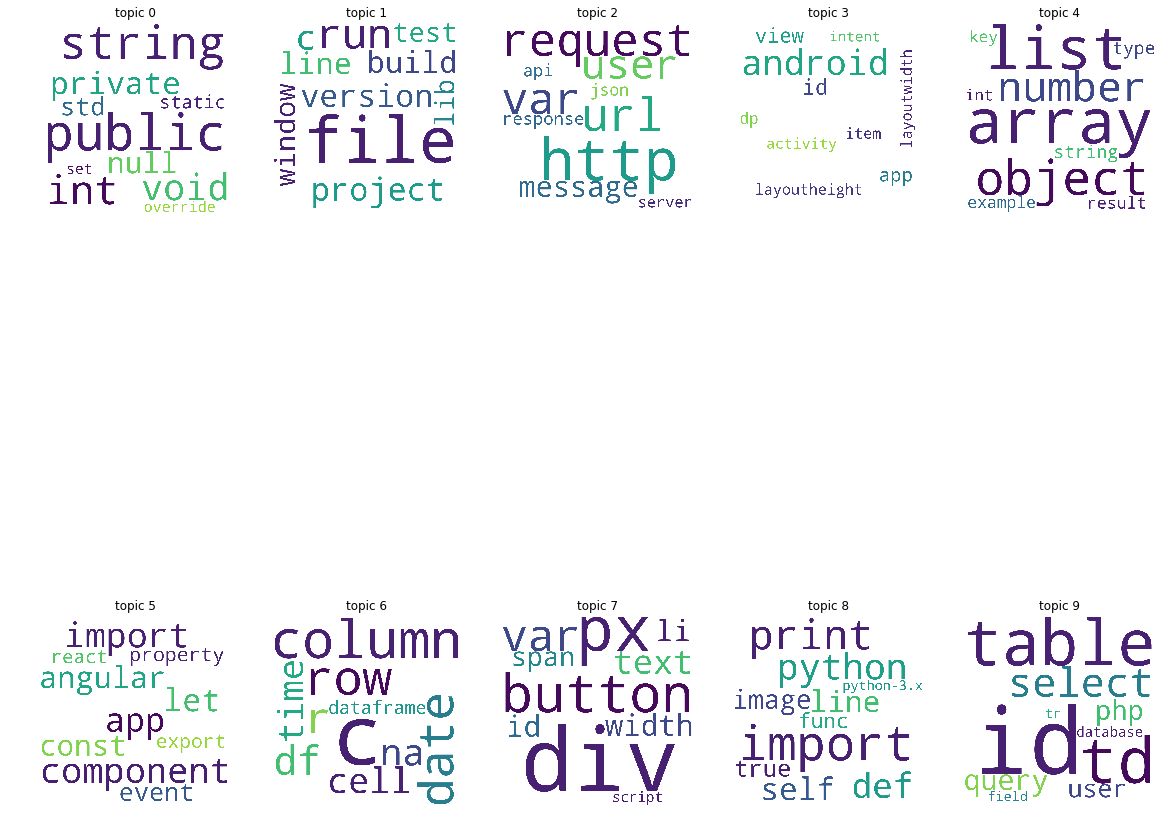

In [221]:
print_topicWordCloud(lda_model, feature_names, 10, 5, 2)

We can also lda model visualizing the importance of each topic and their inter distance:

In [222]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, vect, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
4      17.295898        1       1 -110.986481 -167.247650
7      14.050284        1       2  193.405014 -111.336517
1      12.709454        1       3   42.112976 -144.212952
2       9.980406        1       4  137.646194  192.316742
9       9.795675        1       5 -212.726349  -28.996437
5       9.562835        1       6  239.373032   54.046059
0       8.705581        1       7 -166.776733  136.399811
6       8.673146        1       8  -56.439095   -0.248450
8       4.836787        1       9  -15.486931  169.375900
3       4.389933        1      10   83.071754   25.376600, topic_info=     Category          Freq                Term         Total  loglift  \
term                                                                     
61    Default  18533.000000             android  18533.000000  30.0000   
1452  Default  23311.000000              public  23311.000000  29.0000   
525   Default  26995.000000                 div  26995.000000  28.0000   
1775  Default  25173.000000              string  25173.000000  27.0000   
695   Default  23715.000000                file  23715.000000  26.0000   
875   Default  17175.000000              import  17175.000000  25.0000   
852   Default  25652.000000                  id  25652.000000  24.0000   
926   Default  18202.000000                 int  18202.000000  23.0000   
2007  Default  11787.000000                void  11787.000000  22.0000   
232   Default  16942.000000                   c  16942.000000  21.0000   
1418  Default   8701.000000               print   8701.000000  20.0000   
1840  Default  10489.000000                  td  10489.000000  19.0000   
1829  Default  11338.000000               table  11338.000000  18.0000   
1459  Default  10984.000000                  px  10984.000000  17.0000   
1423  Default   8605.000000             private   8605.000000  16.0000   
80    Default  11374.000000                 app  11374.000000  15.0000   
1461  Default   6612.000000              python   6612.000000  14.0000   
844   Default  15201.000000                http  15201.000000  13.0000   
229   Default  10372.000000              button  10372.000000  12.0000   
1648  Default   9625.000000              select   9625.000000  11.0000   
1237  Default  12187.000000                null  12187.000000  10.0000   
314   Default   9026.000000              column   9026.000000   9.0000   
457   Default   5273.000000                 def   5273.000000   8.0000   
868   Default   9949.000000               image   9949.000000   7.0000   
1035  Default  10260.000000                line  10260.000000   6.0000   
1604  Default   9813.000000                 row   9813.000000   5.0000   
1994  Default   7717.000000                view   7717.000000   4.0000   
1961  Default   7497.000000                 url   7497.000000   3.0000   
1560  Default   6955.000000             request   6955.000000   2.0000   
344   Default   6174.000000           component   6174.000000   1.0000   
...       ...           ...                 ...           ...      ...   
1534  Topic10    342.974906      relativelayout    343.874991   3.1232   
1012  Topic10    330.269408     layoutmargintop    331.169491   3.1231   
777   Topic10    279.111750             gravity    280.011899   3.1226   
893   Topic10    278.506228             inflate    279.406704   3.1226   
1997  Topic10    314.088843           viewgroup    315.135201   3.1225   
1618  Topic10   1026.269689  savedinstancestate   1030.330616   3.1219   
1669  Topic10    357.238029      setcontentview    358.947180   3.1211   
931   Topic10   1869.709643              intent   1940.100706   3.0889   
1809  Topic10    425.927391       superoncreate    432.600019   3.1103   
1089  Topic10    458.206934        mainactivity    470.917388   3.0985   
1266  Topic10    591.087690            oncreate    623.157503   3.0730   
28   

If we evaluate the model now:

In [223]:
evaluate_model(df, X_topics, top_words_arr)

,Tag proposed,Tags from stackoverflow
Question 0,c column row,python pandas
Question 1,file run c,c++
Question 5,component import app,angular typescript
Question 3,array list object,javascript arrays
Question 18,array list object,c#
Question 20,component import app,ios swift


- Question 1/3 seem to give keywords close to the ones from stackoverflow
The other keywords seem not to be consistent.

Let's filter these topwords using the similarity criteria.

In [224]:
top_words_arr_final = filter_by_similarity(model, n_topics, top_words_arr)
top_words_arr_final

[['public', 'void', 'null'],
 ['project', 'line', 'build'],
 ['response', 'server', 'http'],
 ['activity', 'intent', 'android'],
 ['object', 'number', 'type'],
 ['react', 'import', 'export'],
 ['time', 'dataframe', 'date'],
 ['width', 'span', 'script'],
 ['func', 'python-3.x', 'self'],
 ['tr', 'query', 'database']]

What we can see is that we miss **c** and **angular** tags.
If we evaluate the model:

In [225]:
evaluate_model(df, X_topics, top_words_arr_final)

,Tag proposed,Tags from stackoverflow
Question 0,time dataframe date,python pandas
Question 1,project line build,c++
Question 5,react import export,angular typescript
Question 3,object number type,javascript arrays
Question 18,object number type,c#
Question 20,react import export,ios swift


Only question 0 seem to give keywords consistent with the ones from stackoverflow.

### 2.2.2 With 20 topics

Let's continue with the same model (LDA) with 20-topics and keep 10 top words for each topics.

In [226]:
# train LDA model
n_topics = 20
lda_model = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=random_state,
                                n_jobs=-1)
X_topics = lda_model.fit_transform(tf)
n_top_words = 10
top_words_arr = print_top_words(lda_model, feature_names, n_top_words)

Topic #0: int std include const foo void template vector c main
Topic #1: run server time message start thread process window connection log
Topic #2: c date r df na dataframe group time plot year
Topic #3: android id view app dp layoutheight layoutwidth activity intent wrapcontent
Topic #4: array list number string result variable char output loop example
Topic #5: public string void private int static method override null set
Topic #6: row column index col table employee datatable tree merge search
Topic #7: id table select query database product sql field user null
Topic #8: import line python print file def self lib python-3.x nan
Topic #9: import component let angular const export react func state render
Topic #10: px width color height style position center leave image bar
Topic #11: test item map version info http dependency xml java groupid
Topic #12: element child cell node end event parent text tag set
Topic #13: user http request url response api json password post message
T

and display topwords as wordcloud:

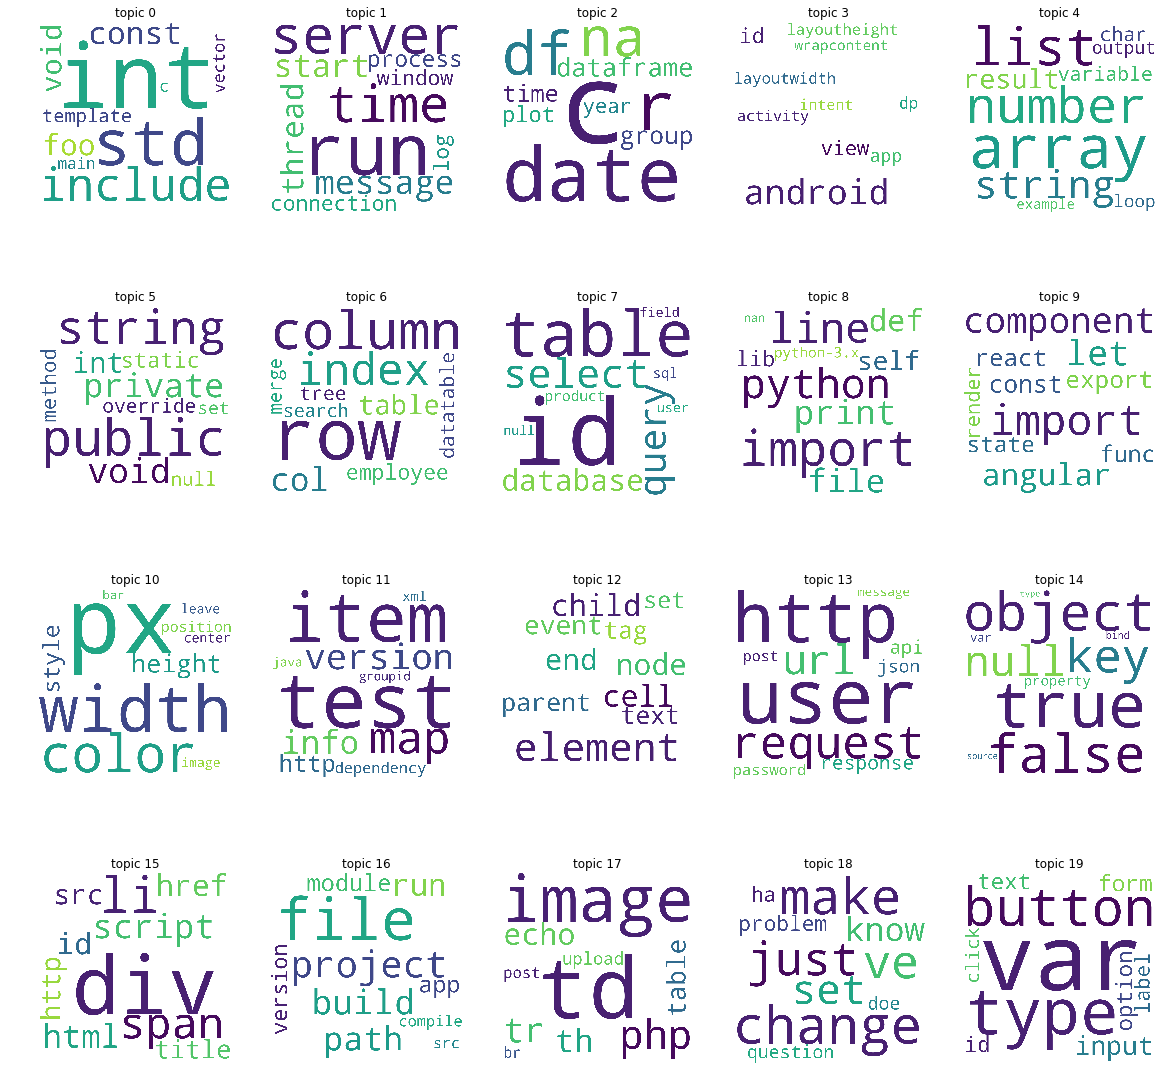

In [227]:
print_topicWordCloud(lda_model, feature_names, 20, 5, 4)

In [228]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, vect, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
18     10.924179        1       1    1.230497  -20.340246
4       9.740066        1       2  -46.620480  -39.127762
13      7.441769        1       3   99.058037   32.386673
16      6.467974        1       4  104.940430  -24.550409
5       6.084643        1       5  -92.719360  -81.235596
7       5.927561        1       6 -100.931557   30.859848
19      5.738805        1       7 -102.490295  -26.050007
15      5.274451        1       8    2.799793 -134.021637
2       5.043161        1       9   12.410705  -70.764336
1       5.026711        1      10   53.840122  -45.887203
10      4.774134        1      11  -46.923126   10.341793
8       4.442604        1      12    0.490672   91.258308
9       3.800512        1      13  -59.903984 -134.734528
3       3.536777        1      14    0.842168   32.525188
14      3.161960        1      15  -33.136570  -86.308006
0       2.797076        1      16  101.425644  -83.488113
17      2.728849        1      17   47.373623    5.434779
12      2.638626        1      18   51.395088   64.294434
11      2.626763        1      19  -52.745483   67.221344
6       1.823380        1      20   52.579262 -110.694702, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
525   Default  27104.000000          div  27104.000000  30.0000  30.0000
1452  Default  23152.000000       public  23152.000000  29.0000  29.0000
61    Default  18296.000000      android  18296.000000  28.0000  28.0000
1775  Default  25025.000000       string  25025.000000  27.0000  27.0000
926   Default  18299.000000          int  18299.000000  26.0000  26.0000
695   Default  23703.000000         file  23703.000000  25.0000  25.0000
852   Default  25590.000000           id  25590.000000  24.0000  24.0000
1604  Default  10023.000000          row  10023.000000  23.0000  23.0000
875   Default  17086.000000       import  17086.000000  22.0000  22.0000
1840  Default  10661.000000           td  10661.000000  21.0000  21.0000
1978  Default  17727.000000          var  17727.000000  20.0000  20.0000
314   Default   9182.000000       column   9182.000000  19.0000  19.0000
1918  Default  15426.000000         true  15426.000000  18.0000  18.0000
1459  Default  11043.000000           px  11043.000000  17.0000  17.0000
1245  Default  11735.000000       object  11735.000000  16.0000  16.0000
232   Default  16963.000000            c  16963.000000  15.0000  15.0000
1852  Default   9974.000000         test   9974.000000  14.0000  14.0000
868   Default   9992.000000        image   9992.000000  13.0000  13.0000
676   Default  10715.000000        false  10715.000000  12.0000  12.0000
2007  Default  11743.000000         void  11743.000000  11.0000  11.0000
1829  Default  11407.000000        table  11407.000000  10.0000  10.0000
1237  Default  12197.000000         null  12197.000000   9.0000   9.0000
953   Default   8361.000000         item   8361.000000   8.0000   8.0000
984   Default   7826.000000          key   7826.000000   7.0000   7.0000
1423  Default   8552.000000      private   8552.000000   6.0000   6.0000
1924  Default  17722.000000         type  17722.000000   5.0000   5.0000
913   Default  10648.000000        input  10648.000000   4.0000   4.0000
229   Default  10363.000000       button  10363.000000   3.0000   3.0000
885   Default   5450.000000        index   5450.000000   2.0000   2.0000
1022  Default   8169.000000          let   8169.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
436   Topic20    837.990028    datatable    854.725725   3.9847  -4.0522
214   Topic20    327.625288        brand    334.234283   3.9845  -4.9914
1343  Topic20    335.662224   percentage    348.537701   3.9668  -4.9671
1703  Topic20    337.733156        slice    353.75349

What we can see also is that:
- The topic 1 have the biggest importance
- The others seems to be quite separated.
- Some topics seem not to rise useful informations (topic 18)

What we discover is that:
- some words seems to contains more useful information that others.

Let's evaluate the model now:

In [229]:
evaluate_model(df, X_topics, top_words_arr)

,Tag proposed,Tags from stackoverflow
Question 0,c date r,python pandas
Question 1,file project build,c++
Question 5,import component let,angular typescript
Question 3,array list number,javascript arrays
Question 18,public string void,c#
Question 20,change make just,ios swift


Only keywords for question 5 seem to be correct.
We can also interpret keywords for question 18 not so far from the ones proposed by stackoverflow.

If we filter by similiarity each keywords:

In [230]:
top_words_arr_final = filter_by_similarity(model, n_topics, top_words_arr)
top_words_arr_final

[['vector', 'c', 'main'],
 ['log', 'start', 'run'],
 ['plot', 'year', 'date'],
 ['intent', 'wrapcontent', 'android'],
 ['example', 'list', 'number'],
 ['public', 'void', 'null'],
 ['tree', 'merge', 'search'],
 ['sql', 'query', 'database'],
 ['lib', 'python-3.x', 'nan'],
 ['state', 'render', 'import'],
 ['color', 'height', 'image'],
 ['java', 'groupid', 'http'],
 ['tag', 'set', 'parent'],
 ['response', 'password', 'url'],
 ['bind', 'source', 'type'],
 ['title', 'html', 'http'],
 ['src', 'project', 'build'],
 ['post', 'tr', 'br'],
 ['just', 'problem', 'question'],
 ['button', 'form', 'click']]

We can see that **c** flag is correctly extracted!
The topic 18 is composed on spurious keywords (just/problem/question).

In [231]:
evaluate_model(df, X_topics, top_words_arr_final)

,Tag proposed,Tags from stackoverflow
Question 0,plot year date,python pandas
Question 1,src project build,c++
Question 5,state render import,angular typescript
Question 3,example list number,javascript arrays
Question 18,public void null,c#
Question 20,just problem question,ios swift


Not really easy to interpret the tag proposed by our model.

### 2.2.2 With 40 topics

Let's do a try now with 40 topics and 20 top words:

In [232]:
# train LDA model
n_topics = 40
lda_model = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=random_state,
                                n_jobs=-1)
X_topics = lda_model.fit_transform(tf)
n_top_words = 20
top_words_arr = print_top_words(lda_model, feature_names, n_top_words)

Topic #0: view override void public context int intent val activity position null private cout fragment savedinstancestate bundle final protect endl extend
Topic #1: string public private void static int exception method null throw systemoutprintln catch final list java boolean override arraylist double main
Topic #2: set message day month report language default team cart enable disable week sound add topic chat aws cookie reset locale
Topic #3: android id app dp layoutheight layoutwidth wrapcontent matchparent notification layout apk http xmlns textview schemasandroidcom text tool true linearlayout color
Topic #4: time question case just variable know make wa example count problem ve second result start end look answer different don
Topic #5: component angular export react state render nodemodules const app prop npm constructor default extend webpack core let dist action typescript
Topic #6: column row index df group dataframe col year pandas frame age level dataset look apply interv

And display topwords as wordcloud:

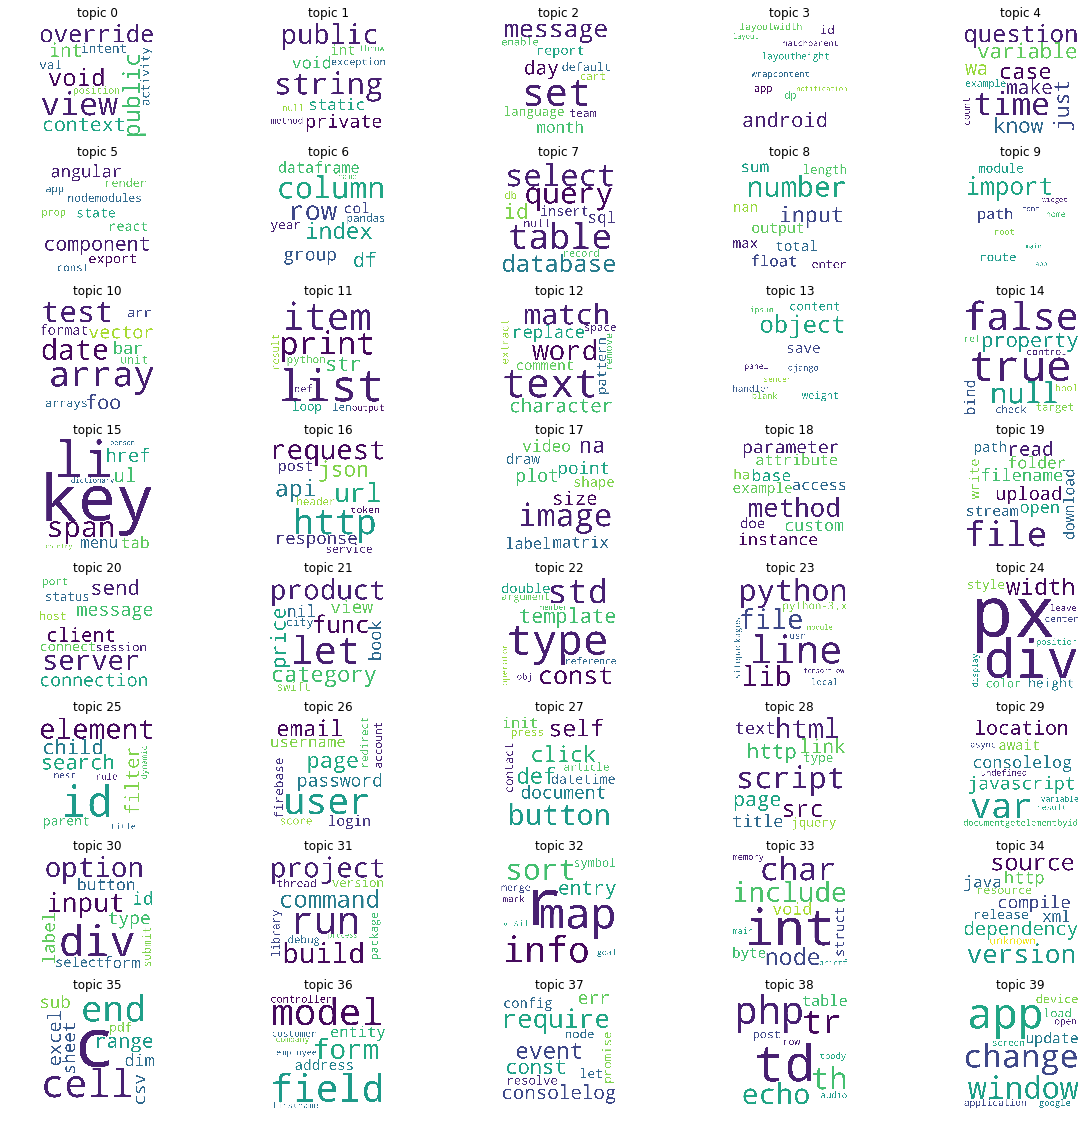

In [233]:
print_topicWordCloud(lda_model, feature_names, 40, 5, 8)

In [234]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, vect, mds='tsne')
panel

PreparedData(topic_coordinates=           Freq  cluster  topics          x          y
topic                                                 
4      8.166177        1       1   8.760641   3.666276
31     4.420737        1       2 -33.818211  -8.130260
24     4.350740        1       3 -42.028843  10.427238
39     4.273869        1       4  -6.449356   4.809436
1      4.255605        1       5 -55.406166 -39.860607
18     4.106318        1       6   4.560663  16.985764
16     3.559607        1       7 -17.266491  -7.111937
30     3.526486        1       8 -16.393579 -25.255095
7      3.503719        1       9   2.574228 -30.127796
28     3.419909        1      10 -25.711283   6.965937
17     2.742442        1      11  16.087631 -10.588739
5      2.534924        1      12  -1.918423 -11.278160
0      2.483442        1      13 -47.214478 -51.302818
22     2.435456        1      14  -0.455393  34.581963
33     2.380953        1      15  -8.391163 -65.847031
20     2.353139        1      16  39.636448  29.757015
3      2.337717        1      17 -27.797876 -43.600933
26     2.296333        1      18  60.677158 -14.998056
6      2.275815        1      19  20.276628 -28.066854
19     2.181138        1      20 -36.688198 -25.065071
8      2.102506        1      21  51.921101   7.904130
11     2.069149        1      22  37.424110 -19.916103
34     2.042499        1      23 -50.782516  -9.085684
23     1.951290        1      24  41.080357 -41.213402
14     1.871052        1      25   2.440489  59.388748
35     1.827583        1      26 -53.863640  29.447739
10     1.757251        1      27 -29.400509  30.123779
21     1.683046        1      28  24.900429  14.077459
38     1.643983        1      29  10.205443 -47.038834
12     1.636496        1      30 -13.187998  21.217968
25     1.613584        1      31 -10.427265 -43.137157
29     1.572634        1      32  26.298891 -62.653198
15     1.541219        1      33 -31.952600 -70.861847
36     1.507723        1      34  25.920622  52.087391
9      1.495281        1      35 -68.498558 -17.624727
2      1.461899        1      36  18.277966  32.461823
37     1.456149        1      37 -17.189663  47.534233
27     1.314010        1      38  33.214123  -1.723775
13     0.959432        1      39 -43.325771  53.215145
32     0.888692        1      40 -68.959343  12.103094, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
695   Default  23756.000000        file  23756.000000  30.0000  30.0000
525   Default  27151.000000         div  27151.000000  29.0000  29.0000
1978  Default  17951.000000         var  17951.000000  28.0000  28.0000
1775  Default  25040.000000      string  25040.000000  27.0000  27.0000
852   Default  25714.000000          id  25714.000000  26.0000  26.0000
875   Default  17168.000000      import  17168.000000  25.0000  25.0000
61    Default  18229.000000     android  18229.000000  24.0000  24.0000
232   Default  17063.000000           c  17063.000000  23.0000  23.0000
1452  Default  23129.000000      public  23129.000000  22.0000  22.0000
1964  Default  16514.000000        user  16514.000000  21.0000  21.0000
1245  Default  11873.000000      object  11873.000000  20.0000  20.0000
1668  Default  13402.000000         set  13402.000000  19.0000  19.0000
926   Default  18166.000000         int  18166.000000  18.0000  18.0000
1918  Default  15407.000000        true  15407.000000  17.0000  17.0000
1042  Default  12970.000000        list  12970.000000  16.0000  16.0000
110   Default  10799.000000       array  10799.000000  15.0000  15.0000
1840  Default  10608.000000          td  10608.000000  14.0000  14.0000
1924  Default  17721.000000        type  17721.000000  13.0000  13.0000
676   Default  10693.000000       false  10693.000000  12.0000  12.0000
1853  Default  12292.000000        text  12292.000000  11.0000  11.0000
229   Default  10471.000000      button  10471.000000  10.0000 

What we can see also is that:
- The topic 1 have the biggest importance
- The others seems to be quite separated.
- Some topics seem not to rise useful informations (topics 3,6, 7 and 16 for example)

What we discover is that:
- some words seems to contains more useful information that others.

Let's evaluate our model now:

In [235]:
evaluate_model(df, X_topics, top_words_arr)

,Tag proposed,Tags from stackoverflow
Question 0,column row index,python pandas
Question 1,run project build,c++
Question 5,component angular export,angular typescript
Question 3,var location javascript,javascript arrays
Question 18,string public private,c#
Question 20,app change window,ios swift


- questions 1/5/3 seem to give keywords quite consistent with the one proposed by stackoverflow.

Let's filter the topwords now:

In [236]:
top_words_arr_final = filter_by_similarity(model, n_topics, top_words_arr, n=5)
top_words_arr_final

[['extend', 'void', 'public', 'null', 'private'],
 ['private', 'void', 'null', 'throw', 'catch'],
 ['locale', 'day', 'month', 'report', 'week'],
 ['tool', 'true', 'linearlayout', 'color', 'android'],
 ['start', 'end', 'look', 'answer', 'question'],
 ['let', 'dist', 'action', 'typescript', 'component'],
 ['interval', 'series', 'ha', 'pddataframe', 'add'],
 ['count', 'query', 'mysql', 'database', 'sql'],
 ['sum', 'output', 'length', 'random', 'distance'],
 ['dashboard', 'paragraph', 'path', 'route', 'widget'],
 ['example', 'hh', 'yyyy', 'slice', 'array'],
 ['keyword', 'tuple', 'nest', 'format', 'iterate'],
 ['replace', 'pattern', 'extract', 'remove', 'expression'],
 ['modelsmodel', 'graphic', 'boundary', 'ipsum', 'lorem'],
 ['summary', 'mode', 'partial', 'readonly', 'textbox'],
 ['dropdown', 'collapse', 'navbar', 'tab', 'item'],
 ['response', 'application', 'send', 'http', 'app'],
 ['numpy', 'image', 'size', 'shape', 'frame'],
 ['add', 'player', 'change', 'game', 'method'],
 ['download',

And evaluate the model:

In [237]:
evaluate_model(df, X_topics, top_words_arr_final)

,Tag proposed,Tags from stackoverflow
Question 0,interval series ha,python pandas
Question 1,run project build,c++
Question 5,let dist action,angular typescript
Question 3,gender alert task,javascript arrays
Question 18,private void null,c#
Question 20,problem task chrome,ios swift


- questions 5/3/20 are correct. Let's keep this model.

# 3 Select and Store final model

Let's store classifier and scaler for later use.

In [240]:
!pip install dill

    100% |################################| 153kB 1.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for dill ... done
  Stored in directory: /root/.cache/pip/wheels/e2/5d/17/f87cb7751896ac629b435a8696f83ee75b11029f5d6f6bda72
Successfully built dill
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [241]:
from sklearn.externals import joblib
import dill as pickle
pickle.dump( vect, open( "./api/stackoverflow/static/vectorizer.pkl", "wb" ) )
pickle.dump(lda_model, open( "./api/stackoverflow/static/model.pkl", "wb" ) )
pickle.dump(top_words_arr_final, open( "./api/stackoverflow/static/mapping.pkl", "wb" ) )